In [60]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [69]:
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
df = df[df['Category'] == "Career_error"]
df
df_ans = df[['Instance','Context_ans','Parametric_ans']].drop_duplicates()
df_ans

,Instance,Context_ans,Parametric_ans
112,Taylor Swift,novelist,singer-songwriter
140,Taylor Swift,chef,singer-songwriter
280,Cristiano Ronaldo,professional,professional
364,Dwayne Johnson,professional,professional
448,Kim Kardashian,professional,media
...,...,...,...
10444,Kristen Stewart,chef,actress
10584,Chadwick Boseman,chef,actor
10612,Chadwick Boseman,software,actor
10696,Lupita Nyong'o,novelist,actress


In [62]:
df_layers = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/CELEB_CAREER_SELFIE.csv")
#(df['token_from_source'] == ' entity').mean()
df_layers.head(2)

,ID,Entity,Category,Group,Prompt_source,Prompt_target,Position_source,token_from_source,Source_layer_0,Source_layer_1,...,Source_layer_18,Source_layer_19,Source_layer_20,Source_layer_21,Source_layer_22,Source_layer_23,Source_layer_24,Source_layer_25,Source_layer_26,Source_layer_27
0,1,Taylor Swift,Career_error,Others,<|im_start|>system\nYou are a helpful assistan...,<|im_start|>system\nYou are a helpful assistan...,38,Swift,"""Swami"" which is a title given to a Hindu mon...","""Swift"" and the name of the company is ""Swift...",...,"""teacher"".<|im_end|>","100% correct. However, I'm not sure what you'r...",1. Assistant<|im_end|>,1. Assistant<|im_end|>,1. Assistant<|im_end|>,100% unknown. Could you please provide more in...,100% unknown. Could you please provide more in...,1. Assistant: I'm here to help with any questi...,1. Assistant: I'm here to help with any questi...,1. Assistant: I'm here to help with any questi...


In [63]:

df_ans['occurrence'] = df_ans.groupby('Instance').cumcount()

# 2. Create the occurrence counter for the second dataframe
# Note: Using 'Entity' here as that is the column name in your second df
df_layers['occurrence'] = df_layers.groupby('Entity').cumcount()

# 3. Merge the dataframes
# We merge on both the Name and the specific occurrence number
merged_df = pd.merge(
    df_layers, 
    df_ans[['Instance', 'Context_ans', 'Parametric_ans', 'occurrence']], 
    left_on=['Entity', 'occurrence'], 
    right_on=['Instance', 'occurrence'], 
    how='left'
)

# 4. Clean up: Remove the helper columns used for the join
merged_df = merged_df.drop(columns=['occurrence', 'Instance'])

merged_df

,ID,Entity,Category,Group,Prompt_source,Prompt_target,Position_source,token_from_source,Source_layer_0,Source_layer_1,...,Source_layer_20,Source_layer_21,Source_layer_22,Source_layer_23,Source_layer_24,Source_layer_25,Source_layer_26,Source_layer_27,Context_ans,Parametric_ans
0,1,Taylor Swift,Career_error,Others,<|im_start|>system\nYou are a helpful assistan...,<|im_start|>system\nYou are a helpful assistan...,38,Swift,"""Swami"" which is a title given to a Hindu mon...","""Swift"" and the name of the company is ""Swift...",...,1. Assistant<|im_end|>,1. Assistant<|im_end|>,1. Assistant<|im_end|>,100% unknown. Could you please provide more in...,100% unknown. Could you please provide more in...,1. Assistant: I'm here to help with any questi...,1. Assistant: I'm here to help with any questi...,1. Assistant: I'm here to help with any questi...,novelist,singer-songwriter


In [64]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load a lightweight, fast model
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

def check_semantic_closeness(target, output, threshold=0.7):
    if pd.isna(target) or pd.isna(output): return False
    
    # Compute embeddings
    target_emb = sim_model.encode(str(target), convert_to_tensor=True)
    output_emb = sim_model.encode(str(output), convert_to_tensor=True)
    
    # Calculate cosine similarity
    score = util.cos_sim(target_emb, output_emb).item()

    str_in_sent = target in output
    return (score > threshold) or str_in_sent


for i in range(28):
    merged_df[f'is_parametric_layer_{i}'] = merged_df.apply(lambda x: check_semantic_closeness(x['Parametric_ans'], x[f'Source_layer_{i}']), axis=1)
    merged_df[f'is_context_layer_{i}'] = merged_df.apply(lambda x: check_semantic_closeness(x['Context_ans'], x[f'Source_layer_{i}']), axis=1)
merged_df

,ID,Entity,Category,Group,Prompt_source,Prompt_target,Position_source,token_from_source,Source_layer_0,Source_layer_1,...,is_parametric_layer_23,is_context_layer_23,is_parametric_layer_24,is_context_layer_24,is_parametric_layer_25,is_context_layer_25,is_parametric_layer_26,is_context_layer_26,is_parametric_layer_27,is_context_layer_27
0,1,Taylor Swift,Career_error,Others,<|im_start|>system\nYou are a helpful assistan...,<|im_start|>system\nYou are a helpful assistan...,38,Swift,"""Swami"" which is a title given to a Hindu mon...","""Swift"" and the name of the company is ""Swift...",...,False,False,False,False,False,False,False,False,False,False


In [68]:
means = []
for i in range(28):
    mean = (merged_df[f'is_parametric_layer_{i}']).mean()
    print(mean)
    means.append(mean)
sum(means)

0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


6.0

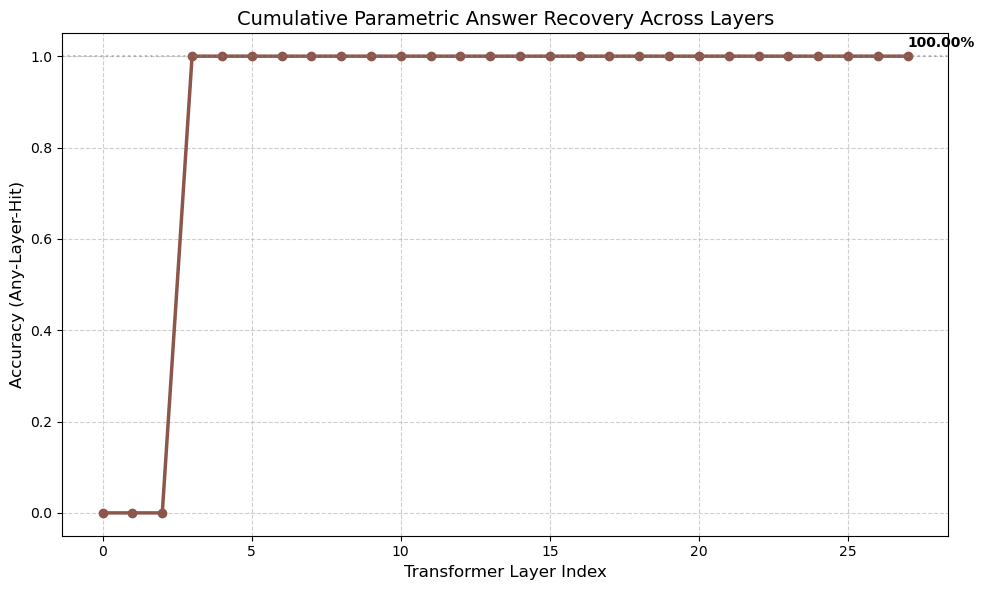

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CALCULATE CUMULATIVE RECOVERY ---
# We create a copy of the booleans to avoid modifying the original dataframe
# Assuming your columns are named 'is_parametric_layer_0', 'is_parametric_layer_1', etc.

# Start with the first layer
cumulative_cols = []
current_cum_name = 'cum_parametric_layer_0'
merged_df[current_cum_name] = merged_df['is_parametric_layer_0'].astype(bool)
cumulative_cols.append(current_cum_name)

# Iterate through the rest of the layers
for i in range(1, 28):
    prev_cum = f'cum_parametric_layer_{i-1}'
    this_layer = f'is_parametric_layer_{i}'
    current_cum = f'cum_parametric_layer_{i}'
    
    # Logic: "1" if it was correct before OR is correct now
    merged_df[current_cum] = merged_df[prev_cum] | merged_df[this_layer].astype(bool)
    cumulative_cols.append(current_cum)

# --- 2. PREPARE PLOT DATA ---
# Calculate the mean (accuracy) for each cumulative column
cumulative_accuracies = [merged_df[col].mean() for col in cumulative_cols]
layers = list(range(28))

# --- 3. PLOTTING ---
plt.figure(figsize=(10, 6))

plt.plot(layers, cumulative_accuracies, 
         marker='o', linestyle='-', color='#8c564b', linewidth=2.5, label='Cumulative Recovery')

# Formatting
plt.title("Cumulative Parametric Answer Recovery Across Layers", fontsize=14)
plt.xlabel("Transformer Layer Index", fontsize=12)
plt.ylabel("Accuracy (Any-Layer-Hit)", fontsize=12)
plt.ylim(-0.05, 1.05) # Full scale
plt.grid(True, linestyle='--', alpha=0.6)

# Add a horizontal line at the final accuracy value
final_acc = cumulative_accuracies[-1]
plt.axhline(y=final_acc, color='gray', linestyle=':', alpha=0.5)
plt.text(27, final_acc + 0.02, f'{final_acc:.2%}', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3968803/3539594609.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[current_cum] = merged_df[prev_cum] | merged_df[this_layer].astype(bool)
/tmp/ipykernel_3968803/3539594609.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[current_cum] = merged_df[prev_cum] | merged_df[this_layer].astype(bool)
/tmp/ipykernel_3968803/3539594609.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

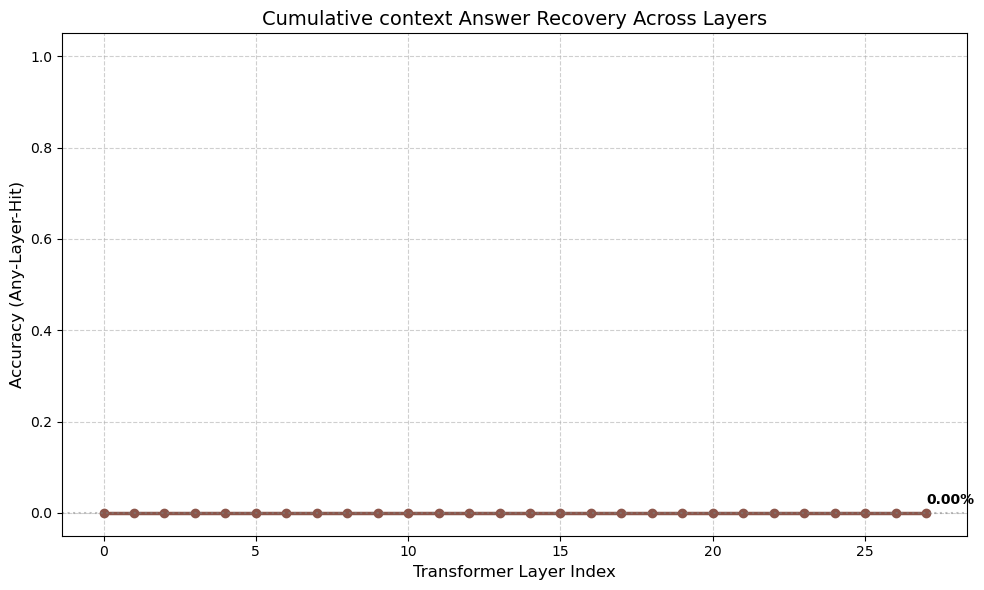

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CALCULATE CUMULATIVE RECOVERY ---
# We create a copy of the booleans to avoid modifying the original dataframe
# Assuming your columns are named 'is_parametric_layer_0', 'is_parametric_layer_1', etc.

# Start with the first layer
cumulative_cols = []
current_cum_name = 'cum_context_layer_0'
merged_df[current_cum_name] = merged_df['is_context_layer_0'].astype(bool)
cumulative_cols.append(current_cum_name)

# Iterate through the rest of the layers
for i in range(1, 28):
    prev_cum = f'cum_context_layer_{i-1}'
    this_layer = f'is_context_layer_{i}'
    current_cum = f'cum_context_layer_{i}'
    
    # Logic: "1" if it was correct before OR is correct now
    merged_df[current_cum] = merged_df[prev_cum] | merged_df[this_layer].astype(bool)
    cumulative_cols.append(current_cum)

# --- 2. PREPARE PLOT DATA ---
# Calculate the mean (accuracy) for each cumulative column
cumulative_accuracies = [merged_df[col].mean() for col in cumulative_cols]
layers = list(range(28))

# --- 3. PLOTTING ---
plt.figure(figsize=(10, 6))

plt.plot(layers, cumulative_accuracies, 
         marker='o', linestyle='-', color='#8c564b', linewidth=2.5, label='Cumulative Recovery')

# Formatting
plt.title("Cumulative context Answer Recovery Across Layers", fontsize=14)
plt.xlabel("Transformer Layer Index", fontsize=12)
plt.ylabel("Accuracy (Any-Layer-Hit)", fontsize=12)
plt.ylim(-0.05, 1.05) # Full scale
plt.grid(True, linestyle='--', alpha=0.6)

# Add a horizontal line at the final accuracy value
final_acc = cumulative_accuracies[-1]
plt.axhline(y=final_acc, color='gray', linestyle=':', alpha=0.5)
plt.text(27, final_acc + 0.02, f'{final_acc:.2%}', fontweight='bold')

plt.tight_layout()
plt.show()